In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# For use on local machine
%cd ..

C:\Users\efurst1\PycharmProjects\LIDC_GDRO


In [2]:
# For use in google colab
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd LIDC_GDRO/

Cloning into 'LIDC_GDRO'...
remote: Enumerating objects: 4523, done.
remote: Counting objects: 100% (1095/1095), done.
remote: Compressing objects: 100% (532/532), done.
remote: Total 4523 (delta 604), reused 1047 (delta 560), pack-reused 3428
Receiving objects: 100% (4523/4523), 141.92 MiB | 15.55 MiB/s, done.
Resolving deltas: 100% (3752/3752), done.
Checking out files: 100% (5464/5464), done.
/content/LIDC_GDRO


In [22]:
!git pull

remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 15 (delta 9), reused 13 (delta 7), pack-reused 0
Unpacking objects: 100% (15/15), done.
From https://github.com/mtzig/LIDC_GDRO
   fb7848c..9ced8e8  main       -> origin/main
Updating fb7848c..9ced8e8
Fast-forward
 utils/cluster_utils.py    | 29 +++++++++++++++++++++++++++++
 utils/image_data_utils.py |  2 +-
 2 files changed, 30 insertions(+), 1 deletion(-)


In [4]:
!git branch

* main


In [5]:
from utils import data_utils, image_data_utils
import datasets
import dataloaders
import models
import torch
import loss
import train_eval
import pandas as pd
import numpy as np
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [61]:
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 128

hparams = {"eta": 0.01, "gamma": 1.5}
lr = 0.0005
weight_decay = 0.005

# model_class = models.NeuralNetwork
# model_args = (512, 64, 36, 2)

model_class = models.TransferModel18
model_args = (True, False, True, device)


print(f'Using device {device}')

Using device cuda


# Load and process data

## LIDC

In [ ]:
# get LIDC data

df = data_utils.preprocess_data(
    *data_utils.load_lidc(
        data_root='data/',
        feature_path='LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv',
        subclass_path='subclass_labels/mode_label.csv'),#'train_test_splits/LIDC_data_split.csv'),
    subclass_column='cluster')
df

,noduleID,Area,ConvexArea,Perimeter,ConvexPerimeter,EquivDiameter,MajorAxisLength,MinorAxisLength,Elongation,Compactness,...,Energy,Homogeneity,Entropy,x_3rdordermoment,Inversevariance,Sumaverage,Variance,Clustertendency,malignancy,subclass
0,1,2.858687,2.860629,2.688148,2.516192,2.529142,2.152152,2.813053,-0.566245,1.320561,...,-0.963124,1.215927,1.947525,-0.236002,1.126182,0.600376,-0.063268,0.050018,1,2.0
1,2,2.269679,1.917109,1.552253,1.954211,2.172407,2.083068,1.908277,0.372004,-0.174280,...,-0.927742,1.430238,1.621591,-0.058623,1.103481,-1.146938,-0.645093,-0.643952,1,1.0
2,3,2.313185,2.229738,2.190760,2.041805,2.199868,1.874439,2.186214,-0.255019,0.950395,...,-0.945433,1.460853,1.847238,-0.246037,1.398599,-0.467185,-0.232066,-0.147096,1,2.0
3,4,-0.263723,-0.291010,-0.148363,-0.108683,-0.089644,-0.011315,-0.234322,0.710524,-0.132838,...,-0.538540,-0.131171,0.175778,-0.267807,-0.190498,-0.449756,-0.296948,-0.288822,1,1.0
4,5,0.020741,-0.054425,0.028349,0.150845,0.295177,0.006211,0.487526,-1.035506,-0.496377,...,-0.697759,2.636502,0.510070,-0.103826,3.044449,0.182066,-0.094918,-0.029805,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2682,2687,-0.240296,-0.257212,-0.100039,-0.083864,-0.054589,0.003926,-0.153305,0.475334,-0.047636,...,-0.538540,1.154695,0.192493,-0.247935,1.080780,-1.299447,-0.640346,-0.630920,1,1.0
2683,2688,-0.611773,-0.589556,-0.677492,-0.727535,-0.749732,-0.699862,-0.750687,0.057965,-0.302033,...,0.505227,-0.841459,-0.810383,0.107726,-1.075852,-0.253673,-0.268991,-0.306741,0,0.0
2684,2689,-0.601733,-0.589556,-0.665766,-0.722959,-0.724538,-0.776367,-0.636464,-0.813931,-0.344997,...,0.346008,0.181111,-0.710095,-0.272345,-0.383460,-1.321234,-0.724218,-0.753098,0,0.0
2685,2690,0.368791,0.300451,0.443243,0.588025,0.683606,0.488672,0.810378,-0.554397,-0.128012,...,-0.803905,1.093463,0.869434,-0.119738,0.989974,0.731098,-0.221516,-0.153612,1,1.0


In [ ]:
# get train/test flags
train_split = pd.read_csv("data/train_test_splits/LIDC_data_split.csv")

# create train/test dataframes
train_df = df[df["noduleID"].isin(train_split[train_split["split"] == 0]["noduleID"].values)]
val_df = df[df["noduleID"].isin(train_split[train_split["split"] == 1]["noduleID"].values)]
test_df = df[df["noduleID"].isin(train_split[train_split["split"] == 2]["noduleID"].values)]

In [ ]:
train_dataloader = data_utils.create_dataloader(train_df, batch_size)
val_dataloader = data_utils.create_dataloader(val_df, len(val_df))
test_dataloader = data_utils.create_dataloader(test_df, len(test_df))

## LIDC CNN features

In [8]:
cnn_train, cnn_val, cnn_test = image_data_utils.get_features()

In [9]:
train_dataloader = data_utils.create_dataloader(cnn_train, batch_size=batch_size, is_dataframe=False)
val_dataloader = data_utils.create_dataloader(cnn_val, batch_size=batch_size, is_dataframe=False)
test_dataloader = data_utils.create_dataloader(cnn_test, batch_size=batch_size, is_dataframe=False)

# LIDC Images

In [77]:
img_train, img_val, img_test = image_data_utils.get_features(subclass='spic_groups', images=True, device=device, subclass_file='data/train_test_splits/LIDC_data_split.csv')
train_dataloader = data_utils.create_dataloader(img_train, batch_size=batch_size, is_dataframe=False)
val_dataloader = data_utils.create_dataloader(img_val, batch_size=batch_size, is_dataframe=False)
test_dataloader = data_utils.create_dataloader(img_test, batch_size=batch_size, is_dataframe=False)

## Waterbirds

In [ ]:
# download waterbirds through wilds

!pip install wilds
from wilds import get_dataset

get_dataset(dataset="waterbirds", download=True)

In [ ]:
from PIL import Image

In [ ]:
metadata_df = pd.read_csv('data/waterbirds_v1.0/metadata.csv')

In [ ]:
convert_resize = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((200, 200), antialias=True)])

train_df, val_df, test_df = [metadata_df[metadata_df['split'] == split] for split in [0, 1, 2]]

dataset_list = []

# If GPU memory is limited, images can be loaded as they are required
# This is much slower but may be necessary
# If false, all images are loaded up-front, which is also slow but only happens once
on_demand = False

for df in [train_df, val_df, test_df]:
    if on_demand:
        dataset_list.append(datasets.OnDemandImageDataset(df, 'data/waterbirds_v1.0/', transform=convert_resize, device=device))
    else:
        img_tensors = []
        for i in range(len(df.index)):
            img_path = metadata_df.iloc[i, 1]
            img_tensors.append(convert_resize(Image.open('data/waterbirds_v1.0/' + img_path)).squeeze().to(device))
        features = torch.stack(img_tensors)
        labels = torch.LongTensor([metadata_df.iloc[:, 2]]).squeeze().to(device)
        subclasses = torch.LongTensor([2 * metadata_df.iloc[:, 2] + metadata_df.iloc[:, 4]]).squeeze().to(device)

        dataset_list.append(datasets.SubclassedDataset(features, labels, subclasses))

In [ ]:
# smaller dataloaders for prototyping
train_dataloader, val_dataloader, test_dataloader = [dataloaders.InfiniteDataLoader(torch.utils.data.Subset(dataset, range(0, len(dataset), 2)), batch_size=batch_size) for dataset in dataset_list]

In [ ]:
# full size dataloaders
train_dataloader, val_dataloader, test_dataloader = [dataloaders.InfiniteDataLoader(dataset, batch_size=batch_size) for dataset in dataset_list]


# Test convergence of combinations of ERM and GDRO

In [78]:
N = 100
epochs = 20
subtypes = ["Overall", "Unspiculated benign", "Spiculated benign", "Spiculated malignant", "Unspiculated malignant"]
# subtypes = ["Overall", "Land on land", "Land on water", "Water on land", "Water on water"]
# subtypes = ["Overall", "Likely Benign", "Somewhat Benign", "Somewhat Malignant", "Likely Malignant"]

# test_algorithms = ["ERM", "GDRO", "Sharp", "Smooth", "ReverseSmooth", "Dynamic", "ExtraERM", "ExtraGDRO", "Halfway"]
# test_algorithms = ["Mix" + str(t) for t in [0.4, 0.5, 0.6, 0.7, 0.8]]
# test_algorithms = ["ERM", "GDRO", *["Dynamic" + str(t) for t in [0.01, 0.05, 0.1, 0.5]]]
test_algorithms = ["ERM", "GDRO"]
keep_old =        [False, False]

record_roc_data = False

In [ ]:
if not sum(keep_old):
    results = {}
    if record_roc_data:
        roc_data = {}  # For ROC curve

for a in range(len(test_algorithms)):
    algorithm = test_algorithms[a]

    if keep_old[a] and algorithm in results:
        print(f"Keeping old results for {algorithm}")
    else:
        print(f"Running test: {algorithm}")

        results[algorithm] = np.zeros(N * epochs * len(subtypes))
        if record_roc_data:
            roc_data[algorithm] = [None, None]

        for n in range(N):

            print(f"Trial {n + 1}/{N}")

            # create and train model
            # model = models.NeuralNetwork(64, 32, 32, 2)
            # model.to(device)
            model = model_class(*model_args).to(device)

            if (algorithm == "ERM"):
                loss_fn = loss.ERMLoss(model, torch.nn.CrossEntropyLoss())
            elif (algorithm == "GDRO"):
                loss_fn = loss.GDROLoss(model, torch.nn.CrossEntropyLoss(), hparams["eta"], len(subtypes) - 1, normalize_loss=False)
            elif (algorithm == "NormGDRO"):
                loss_fn = loss.GDROLoss(model, torch.nn.CrossEntropyLoss(), hparams["eta"], len(subtypes) - 1, normalize_loss=True)
            elif (algorithm.startswith("GDRO")):
                loss_fn = loss.GDROLoss(model, torch.nn.CrossEntropyLoss(), float(algorithm[len("GDRO"):]), len(subtypes) - 1, normalize_loss=True)
            elif (algorithm == "Dynamic"):
                loss_fn = loss.DynamicLoss(model, torch.nn.CrossEntropyLoss(), hparams["eta"], hparams["gamma"], len(subtypes) - 1, norm_fn=torch.nn.Softmax(dim=0))
            elif (algorithm.startswith("Dynamic")):
                loss_fn = loss.DynamicLoss(model, torch.nn.CrossEntropyLoss(), float(algorithm[len("Dynamic"):]), hparams["gamma"], len(subtypes) - 1)
            elif (algorithm == "Upweight"):
                loss_fn = loss.UpweightLoss(model, torch.nn.CrossEntropyLoss(), len(subtypes) - 1)
            else:
                loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams, len(subtypes) - 1)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)#, momentum=momentum)

            # scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)
            
            for epoch in range(epochs):
                # print(f'Epoch {epoch + 1} / {epochs}')

                if algorithm == "Sharp":
                    loss_fn.t = epoch / epochs < 0.5  # sharp boundary
                elif algorithm == "Smooth":
                    loss_fn.t = 1 - (epoch / (epochs - 1))  # linear interpolation
                elif algorithm == "ReverseSmooth":
                    loss_fn.t = epoch / (epochs - 1)  # reverse linear interpolation
                elif algorithm == "ExtraERM":
                    loss_fn.t = 2
                elif algorithm == "ExtraGDRO":
                    loss_fn.t = -1
                elif algorithm == "Halfway":
                    loss_fn.t = 0.5
                elif algorithm.startswith("Mix"):
                    loss_fn.t = float(algorithm[3:])  # ex. algorithm == "Mix0.5" => t = 0.5

                train_eval.train(train_dataloader, model, loss_fn, optimizer)
                sensitivities = train_eval.evaluate(test_dataloader, model, num_subclasses=len(subtypes) - 1)
                
                # scheduler.step(train_eval.evaluate(val_dataloader, model, num_subclasses=len(subtypes) - 1)[0])

                for i in range(len(subtypes)):
                    results[algorithm][n * epochs * len(subtypes) + epoch * len(subtypes) + i] = sensitivities[i]
            if record_roc_data:
                with torch.no_grad():
                    preds = model(torch.stack(test_dataloader.dataset.features))
                    probabilities = torch.nn.functional.softmax(preds, dim=1)[:, 1]
                    labels = test_dataloader.dataset.labels
                    if roc_data[algorithm][0] == None:
                        roc_data[algorithm][0] = probabilities
                        roc_data[algorithm][1] = labels
                    else:
                        roc_data[algorithm][0] += probabilities
        if record_roc_data:
            roc_data[algorithm][0] /= N
        
print("Test complete")

results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

# Automatically save and download results from colab
from datetime import datetime
now = "end_to_end_spic_groups"#datetime.now().strftime("%Y%m%d_%H%M%S")
results_df.to_csv(f'results_{now}.csv')

from google.colab import files
files.download(f'results_{now}.csv') 

Running test: ERM
Trial 1/100


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Trial 2/100
Trial 3/100
Trial 4/100
Trial 5/100
Trial 6/100
Trial 7/100
Trial 8/100
Trial 9/100
Trial 10/100
Trial 11/100
Trial 12/100
Trial 13/100
Trial 14/100
Trial 15/100
Trial 16/100
Trial 17/100
Trial 18/100
Trial 19/100
Trial 20/100
Trial 21/100
Trial 22/100
Trial 23/100
Trial 24/100
Trial 25/100
Trial 26/100
Trial 27/100
Trial 28/100
Trial 29/100
Trial 30/100
Trial 31/100
Trial 32/100
Trial 33/100
Trial 34/100
Trial 35/100
Trial 36/100
Trial 37/100
Trial 38/100
Trial 39/100
Trial 40/100
Trial 41/100
Trial 42/100
Trial 43/100
Trial 44/100
Trial 45/100
Trial 46/100
Trial 47/100
Trial 48/100
Trial 49/100
Trial 50/100
Trial 51/100
Trial 52/100
Trial 53/100
Trial 54/100
Trial 55/100
Trial 56/100


In [72]:
from datetime import datetime
now = datetime.now().strftime("%Y%m%d_%H%M%S")
results_df.to_csv(f'results_{now}.csv')

from google.colab import files
files.download(f'results_{now}.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Results Visualization

Data loading and plotting functions to visualize the results given by run.py  
Put the path of the folder containing the results in load_dir and run the cells to see results

In [278]:
import matplotlib.pyplot as plt
load_root = 'test_results/standardized/'
load_dirs = [
    'LIDC_CNN_features_CNN_clusters_20220727_110802/',
    'LIDC_CNN_features_mal_groups_20220722_112147/',
    'LIDC_CNN_features_spic_groups_20220727_110422/',
    'LIDC_designed_features_CNN_clusters_20220727_110110/',
    'LIDC_designed_features_mal_groups_20220727_105545/',
    'LIDC_designed_features_spic_groups_20220727_110025/',
]

In [335]:
pd.read_csv('data/subclass_labels/subclasses.csv')['spic_groups'] == pd.read_csv('data/train_test_splits/LIDC_data_split.csv')['spic_groups']

0       False
1       False
2       False
3       False
4       False
        ...  
1483    False
1484     True
1485     True
1486    False
1487     True
Name: spic_groups, Length: 1488, dtype: bool

## Plot overall accuracy, subclass sensitivites, and worst sensitivity per epoch

In [337]:
def plot_acc(results_df=None):
    global subtypes
    global N
    global epochs
    global algorithms
    
    if results_df is None:
        loaded_accuracies = pd.read_csv(load_dir + 'accuracies.csv')
        N = max(loaded_accuracies["trial"]) + 1
        epochs = max(loaded_accuracies["epoch"]) + 1
        subtypes = list(loaded_accuracies["subtype"].unique())
        algorithms = loaded_accuracies.columns

        results = loaded_accuracies.drop(columns=["subtype", "epoch", "trial"]).to_dict('list')
        results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))
    
    trial_means = results_df.stack().unstack(level=0).mean(axis=1).unstack(level=2)
    worst_group = trial_means.stack().unstack(level=1).drop(columns="Overall").min(axis=1).unstack()
    worst_group.index = pd.MultiIndex.from_tuples([(epoch, "Lower bound") for epoch in worst_group.index], names=["epoch", "subtype"])
    trial_means = pd.concat([trial_means, worst_group])
    
    trial_stds = results_df.stack().unstack(level=0).std(axis=1).unstack(level=2)

    drop_epochs = []  # list(range(40, 100))

    trial_means.drop(drop_epochs, level=0, axis=0, inplace=True)
    # reindex epochs from 1
    trial_means.index = pd.MultiIndex.from_tuples(zip(trial_means.index.get_level_values(0) + 1, trial_means.index.get_level_values(1)), names=["epoch", "subtype"])
    trial_stds.index = pd.MultiIndex.from_tuples(zip(trial_stds.index.get_level_values(0) + 1, trial_stds.index.get_level_values(1)), names=["epoch", "subtype"])
    
    plots = [*subtypes, "Lower bound"]
    # plots = ["Overall", "Lower bound", *subtypes[1:]]
    # plots = subtypes[1:]

    hide = []#["DynamicLoss", "UpweightLoss"]

    w = 2

    f, a = plt.subplots((len(plots) + 1) // w, w)

    if len(plots) > w:
        a = [ax for a0 in a for ax in a0]

    # plot subtypes sensitivity

    #legend=None,xlim=[35, 40],ylim=[0.85,0.88],

    for i in range(len(plots)):
        plot_data = trial_means.drop(columns=hide).xs(plots[i], level=1)
        plot_data.plot(ylim=[0.5,1],xlabel="Epoch",ylabel="Accuracy",kind='line',title=plots[i],ax=a[i],figsize=(6 * w, 6 * ((len(plots) + 1) // w)),grid=True)
        if plots[i] != "Lower bound":
            plot_stds = trial_stds.drop(columns=hide).xs(key=plots[i], level=1)
            for col in plot_data.columns:
                a[i].fill_between(list(plot_data.index), plot_data[col] + 2 * plot_stds[col], plot_data[col] - 2 * plot_stds[col], alpha=0.25)
        

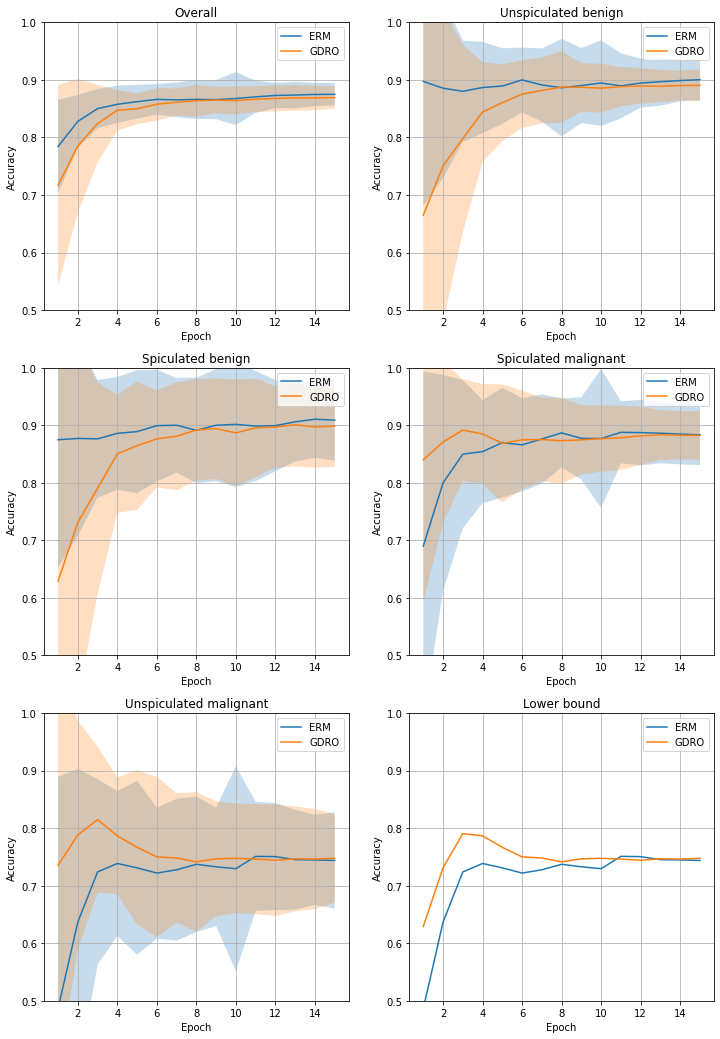

In [343]:
load_dir = load_root + 'LIDC_E2E_spic_groups/'# + load_dirs[3]
plot_acc()

Overall
ERM: 0.8748837209302327
GDRO: 0.869235880398671
ERM greater with p = 0.00


Unspiculated benign
ERM: 0.9003896103896105
GDRO: 0.8906493506493506
ERM greater with p = 0.00


Spiculated benign
ERM: 0.9088888888888889
GDRO: 0.8985185185185186
No significant difference with p = 0.15


Spiculated malignant
ERM: 0.8833333333333334
GDRO: 0.8823076923076925
No significant difference with p = 0.83


Unspiculated malignant
ERM: 0.7438095238095239
GDRO: 0.7476190476190478
No significant difference with p = 0.64




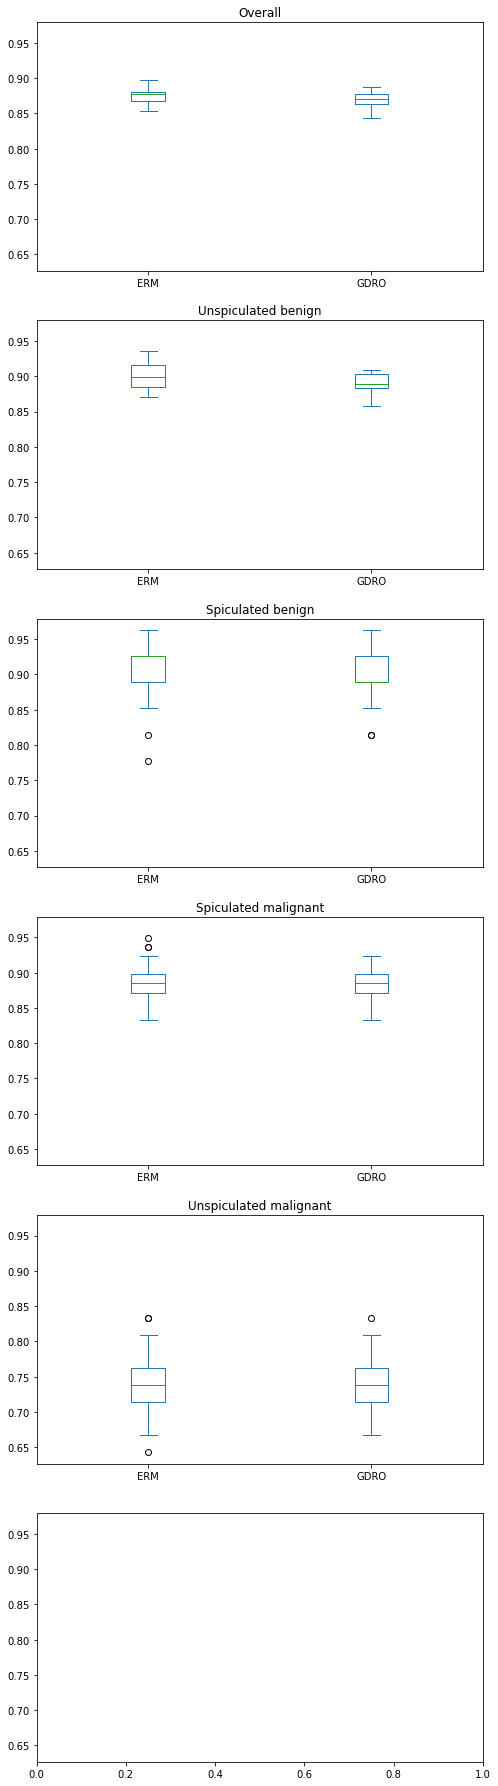

In [344]:
# statisitical tests comparing to ERM
from scipy.stats import ttest_ind

significance_threshold = 0.05

ttest_dataframes = {}

loaded_accuracies = pd.read_csv(load_dir + 'accuracies.csv')
N = max(loaded_accuracies["trial"]) + 1
epochs = max(loaded_accuracies["epoch"]) + 1
subtypes = list(loaded_accuracies["subtype"].unique())
algorithms = loaded_accuracies.columns

results = loaded_accuracies.drop(columns=["subtype", "epoch", "trial"]).to_dict('list')
results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

f, a = plt.subplots(len(subtypes) + 1,1, sharey=True, figsize=(8,32))

for s in range(len(subtypes)):
    epoch = epochs - 1

    subtype_data = results_df.xs(subtypes[s], level=2).xs(epoch, level=1)
    subtype_data.plot(title=subtypes[s], kind='box', ax=a[s])
    
    # worst group data
    # results_df.stack().unstack(level=2).min(axis=1).unstack().xs(epochs - 1, level=1).plot(title='worst', kind='box', ax=a[-1])
    
    erm_data = subtype_data["ERM"].values

    print(subtypes[s])
    for algorithm in results_df.columns:
        if algorithm in ["DynamicLoss", "UpweightLoss"]:
            continue
        if algorithm != "ERM":
            algorithm_data = subtype_data[algorithm].values
            stat, p = ttest_ind(algorithm_data, erm_data)

            print(f'ERM: {erm_data.mean()}')
            print(f'{algorithm}: {algorithm_data.mean()}')
            if p < significance_threshold:
                print(f'{algorithm if stat > 0 else "ERM"} greater with p = {p:.2f}')
            else:
                print(f'No significant difference with p = {p:.2f}')
            print()
    print()

## Plot values of q and g (subclass and loss function weights, respectively)

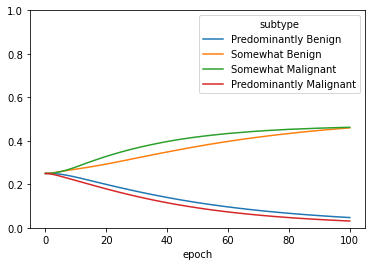

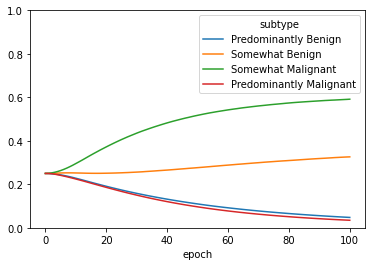

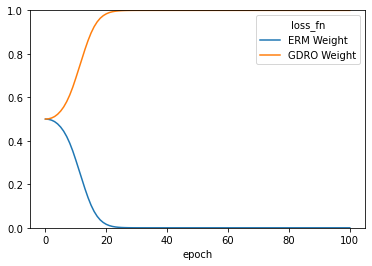

In [332]:
def read_q(path):
    loaded_data = pd.read_csv(load_dir + 'q.csv').dropna(axis=1)
    loaded_data.index = pd.MultiIndex.from_arrays([loaded_data['trial'], loaded_data['epoch'], loaded_data['subtype']], names=['trial', 'epoch', 'subtype'])
    saved_subtypes = loaded_data['subtype']
    loaded_data.drop(columns=['trial', 'epoch', 'subtype'], inplace=True)
    loaded_data = loaded_data.stack().unstack(level=1)
    loaded_data.insert(0, -1, np.ones(len(loaded_data.index)) / len(loaded_data.index.levels[1]))
    loaded_data.columns += 1
    mean_data = loaded_data.stack(level=0).unstack(level=0).mean(axis=1).unstack(level=0).stack(level=0).unstack(level=0)
    mean_data = mean_data.unstack(level=1)
    mean_data = mean_data.loc[:, pd.MultiIndex.from_product([mean_data.columns.levels[0], saved_subtypes.unique()])]
    return mean_data

def read_g(path):
    loaded_data = pd.read_csv(load_dir + 'g.csv').dropna(axis=1)
    loaded_data.index = pd.MultiIndex.from_arrays([loaded_data['trial'], loaded_data['epoch'], loaded_data['loss_fn']], names=['trial', 'epoch', 'loss_fn'])
    saved_subtypes = loaded_data['loss_fn']
    loaded_data.drop(columns=['trial', 'epoch', 'loss_fn'], inplace=True)
    loaded_data = loaded_data.stack().unstack(level=1)
    loaded_data.insert(0, -1, np.ones(len(loaded_data.index)) / len(loaded_data.index.levels[1]))
    loaded_data.columns += 1
    mean_data = loaded_data.stack(level=0).unstack(level=0).mean(axis=1).unstack(level=0).stack(level=0).unstack(level=0)
    mean_data = mean_data.unstack(level=1)
    mean_data = mean_data.loc[:, pd.MultiIndex.from_product([mean_data.columns.levels[0], saved_subtypes.unique()])]
    return mean_data

mean_q = read_q(load_dir + 'q.csv')

for c in mean_q.columns.levels[0]:
    mean_q[c].plot(ylim=[0,1])
    
mean_g = read_g(load_dir + 'g.csv')
for c in mean_g.columns.levels[0]:
    mean_g[c].plot(ylim=[0,1])

## Plot ROC Curve

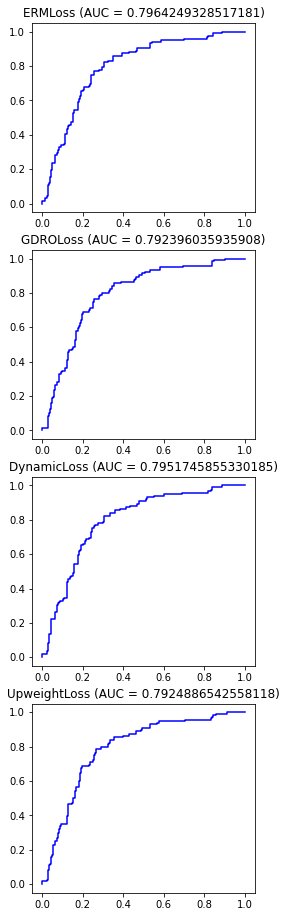

In [ ]:
# ROC curve

from sklearn import metrics

roc_df = pd.read_csv(load_dir + 'ROC.csv')

f, a = plt.subplots(len(roc_df.columns) - 1, 1, figsize=(4,4 * (len(roc_df.columns) - 1)))

for i in range(len(roc_df.columns) - 1):
    c = roc_df.drop(columns='labels').columns[i]
    
    y_true = roc_df['labels']
    y_score = roc_df[c]

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    a[i].plot(fpr, tpr, 'b')
    a[i].set_title(f'{c} (AUC = {auc})')

In [ ]:
loaded_accuracies = pd.read_csv(load_dir + 'accuracies.csv')
N = max(loaded_accuracies["trial"]) + 1
epochs = max(loaded_accuracies["epoch"]) + 1
subtypes = list(loaded_accuracies["subtype"].unique())
algorithms = loaded_accuracies.columns

results = loaded_accuracies.drop(columns=["subtype", "epoch", "trial"]).to_dict('list')
results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

trial_means = results_df.unstack().unstack().mean(axis=0).unstack(level=0).unstack(level=0).stack()
worst_group = trial_means.stack().unstack(level=1).drop(columns="Overall").min(axis=1).unstack()
worst_group.index = pd.MultiIndex.from_tuples([(epoch, "Lower bound") for epoch in worst_group.index], names=["epoch", "subtype"])
trial_means = pd.concat([trial_means, worst_group])
trial_means.stack().unstack(level=0).idxmax(axis=1).unstack(level=1)

,ERMLoss,GDROLoss,DynamicLoss,UpweightLoss
subtype,,,,
Lower bound,13,16,16,15
Overall,15,18,16,15
Spiculated benign,0,34,0,37
Spiculated malignant,13,0,16,0
Unspiculated benign,0,96,0,62
Unspiculated malignant,13,0,16,11


In [ ]:
trial_means.stack().unstack(level=0).max(axis=1).unstack(level=1)

,ERMLoss,GDROLoss,DynamicLoss,UpweightLoss
subtype,,,,
Lower bound,0.689351,0.718182,0.707922,0.719386
Overall,0.753223,0.754219,0.754684,0.755316
Spiculated benign,0.887101,0.860870,0.887971,0.865217
Spiculated malignant,0.689351,0.758312,0.707922,0.759740
Unspiculated benign,0.837544,0.732632,0.841140,0.732281
Unspiculated malignant,0.743902,0.796341,0.756098,0.795854


Overall
ERM: 0.8628737541528239
GDRO: 0.8520348837209302
ERM greater with p = 0.00


Benign
ERM: 0.8968232044198896
GDRO: 0.8422651933701658
ERM greater with p = 0.00


Malignant1
ERM: 0.7159810126582279
GDRO: 0.7976265822784809
GDRO greater with p = 0.00


Malignant2
ERM: 0.9960365853658537
GDRO: 1.0
GDRO greater with p = 0.00




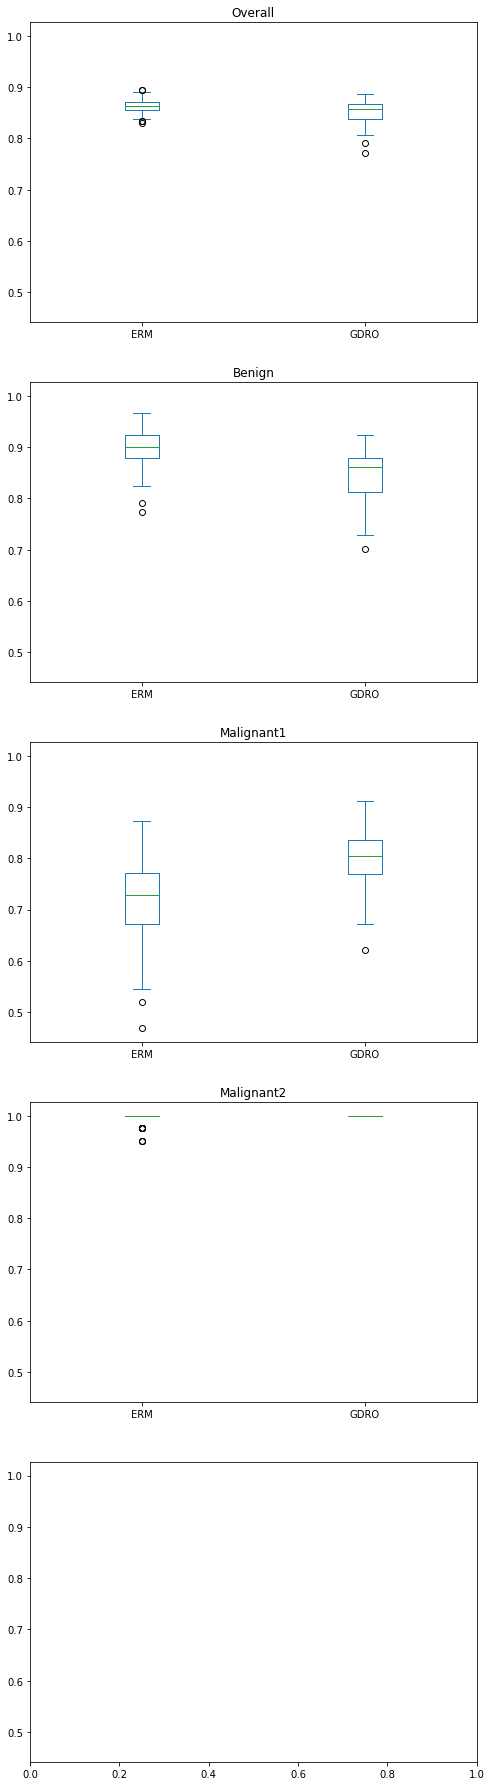

In [ ]:
# statisitical tests comparing to ERM
from scipy.stats import ttest_ind
from IPython.display import display
import seaborn as sns

significance_threshold = 0.05

ttest_dataframes = {}

loaded_accuracies = pd.read_csv('C:\\Users\\efurst1\\Downloads\\results_20220725_212250.csv')#load_dir + 'accuracies.csv')
N = max(loaded_accuracies["trial"]) + 1
epochs = max(loaded_accuracies["epoch"]) + 1
subtypes = list(loaded_accuracies["subtype"].unique())
algorithms = loaded_accuracies.columns

results = loaded_accuracies.drop(columns=["subtype", "epoch", "trial"]).to_dict('list')
results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

f, a = plt.subplots(len(subtypes) + 1,1, sharey=True, figsize=(8,32))

for s in range(len(subtypes)):
#     print(subtype)
#     print()
    epoch = 2  # epochs - 1

    subtype_data = results_df.xs(subtypes[s], level=2).xs(epoch, level=1)
    subtype_data.plot(title=subtypes[s], kind='box', ax=a[s])
    
    # worst group data
    # results_df.stack().unstack(level=2).min(axis=1).unstack().xs(epochs - 1, level=1).plot(title='worst', kind='box', ax=a[-1])

    
    erm_data = subtype_data["ERM"].values

    print(subtypes[s])
    for algorithm in results_df.columns:
        if algorithm != "ERM":
            algorithm_data = subtype_data[algorithm].values
            stat, p = ttest_ind(algorithm_data, erm_data)

            print(f'ERM: {erm_data.mean()}')
            print(f'{algorithm}: {algorithm_data.mean()}')
            if p < significance_threshold:
                print(f'{algorithm if stat > 0 else "ERM"} greater with p = {p:.2f}')
            else:
                print(f'No significant difference with p = {p:.2f}')
            print()
    print()

In [54]:
semantic_feature_names = ['Subtlety', 'InternalStructure', 'Calcification', 'Sphericity', 'Margin', 'Lobulation', 'Spiculation', 'Texture', 'Malignancy']

In [55]:
df = pd.read_csv('data/LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv')

for n in semantic_feature_names:
    df[n.lower()] = df[[n + '_1', n + '_2', n + '_3', n + '_4']].replace(0, np.nan).mode(axis=1).mean(axis=1).apply(np.ceil).astype(int)

In [63]:
df.to_csv('data/LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv')

In [76]:
no_mal3 = df[df['malignancy'] != 3]

In [78]:
import os
in_images = no_mal3[no_mal3['noduleID'].isin(list(map(lambda x: int(x.replace('.txt', '')), os.listdir('data/LIDC(MaxSlices)_Nodules'))))]

In [79]:
spic_subtypes = in_images[['noduleID', 'spiculation', 'malignancy']]

In [83]:
spic_subtypes['spicb'] = (spic_subtypes['spiculation'] > 1).astype(int)

C:\Users\efurst1\AppData\Local\Temp\ipykernel_16912\1440420070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spic_subtypes['spicb'] = (spic_subtypes['spiculation'] > 1).astype(int)


In [86]:
spic_subtypes['malb'] = (spic_subtypes['malignancy'] > 3).astype(int)

C:\Users\efurst1\AppData\Local\Temp\ipykernel_16912\407178938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spic_subtypes['malb'] = (spic_subtypes['malignancy'] > 3).astype(int)


In [112]:
spic_subtypes['spic_subclass'] = list(map(lambda x: [0,3,1,2][x], 2 * spic_subtypes['spicb'] + spic_subtypes['malb']))

C:\Users\efurst1\AppData\Local\Temp\ipykernel_16912\2737252206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spic_subtypes['spic_subclass'] = list(map(lambda x: [0,3,1,2][x], 2 * spic_subtypes['spicb'] + spic_subtypes['malb']))


In [113]:
spic_subtypes['mal_subclass'] = list(map(lambda x: [1,2,4,5].index(x), spic_subtypes['malignancy']))

C:\Users\efurst1\AppData\Local\Temp\ipykernel_16912\2823220019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spic_subtypes['mal_subclass'] = list(map(lambda x: [1,2,4,5].index(x), spic_subtypes['malignancy']))


In [ ]:
[0,3,1,2]

In [114]:
spic_subtypes['spic_subclass_name'] = list(map(lambda x: ["Unspiculated Benign", "Spiculated Benign", "Spiculated Malignant", "Unspiculated Malignant"][x], spic_subtypes['spic_subclass']))

C:\Users\efurst1\AppData\Local\Temp\ipykernel_16912\3259273149.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spic_subtypes['spic_subclass_name'] = list(map(lambda x: ["Unspiculated Benign", "Spiculated Benign", "Spiculated Malignant", "Unspiculated Malignant"][x], spic_subtypes['spic_subclass']))


In [116]:
spic_subtypes['mal_subclass_name'] = list(map(lambda x: ["Highly Unlikely", "Moderately Unlikely", "Moderately Suspicious", "Highly Suspicious"][x], spic_subtypes['mal_subclass']))

C:\Users\efurst1\AppData\Local\Temp\ipykernel_16912\3283806219.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spic_subtypes['mal_subclass_name'] = list(map(lambda x: ["Highly Unlikely", "Moderately Unlikely", "Moderately Suspicious", "Highly Suspicious"][x], spic_subtypes['mal_subclass']))


In [137]:
clusters = pd.read_csv('data/subclass_labels/mode_label (2).csv')

In [138]:
for i in clusters.index:
    spic_subtypes.loc[spic_subtypes['noduleID'] == clusters.at[i, 'noduleID'], 'cluster'] = clusters.at[i, 'cluster'].astype(int)
spic_subtypes['cluster'] = spic_subtypes['cluster'].astype(int)

C:\Users\efurst1\AppData\Local\Temp\ipykernel_16912\2315709388.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spic_subtypes['cluster'] = spic_subtypes['cluster'].astype(int)


In [139]:
spic_subtypes['cluster_name'] = list(map(lambda x: ["Predominantly Benign", "Somewhat Benign", "Somewhat Malignant", "Predominantly Malignant"][x], spic_subtypes['cluster']))

C:\Users\efurst1\AppData\Local\Temp\ipykernel_16912\1983669941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spic_subtypes['cluster_name'] = list(map(lambda x: ["Predominantly Benign", "Somewhat Benign", "Somewhat Malignant", "Predominantly Malignant"][x], spic_subtypes['cluster']))


In [142]:
spic_subtypes[['noduleID', 'spic_subclass', 'spic_subclass_name', 'mal_subclass', 'mal_subclass_name', 'cluster', 'cluster_name']].to_csv('data/subclass_labels/subclasses.csv', index=False)

In [143]:
[sum(spic_subtypes['spic_subclass'] == n) for n in range(4)]

[781, 116, 387, 204]

In [164]:
semantic = pd.read_csv('data/LIDC_semantic_spiculation_malignancy.csv')

In [165]:
semantic = semantic[semantic['malignancy'] != 3]
import os
semantic = semantic[semantic['noduleID'].isin(list(map(lambda x: int(x.replace('.txt', '')), os.listdir('data/LIDC(MaxSlices)_Nodules'))))]
semantic['spicb'] = (semantic['spiculation'] > 1).astype(int)
semantic['malb'] = (semantic['malignancy'] > 3).astype(int)
semantic['spic_subclass'] = list(map(lambda x: [0,3,1,2][x], 2 * spic_subtypes['spicb'] + spic_subtypes['malb']))

In [153]:
[sum(semantic['spic_subclass'] == n) for n in range(4)]

[781, 116, 387, 204]

In [166]:
semantic['spic_b'] = np.where(semantic['spiculation'] > 1, 1, 0)
semantic = semantic[semantic['malignancy'] != 3]
semantic['mal_b'] = np.where(semantic['malignancy'] > 3, 1, 0)
semantic.groupby(['mal_b', 'spic_b']).size()

mal_b  spic_b
0      0         781
       1         116
1      0         204
       1         387
dtype: int64

In [167]:
datasplit = pd.read_csv('data/train_test_splits/LIDC_data_split.csv')
datasplit['malignancy2'] = semantic['malignancy']

In [169]:
semantic['malignancy']

0       5
1       5
2       5
3       4
4       4
       ..
2675    4
2676    2
2677    2
2678    5
2679    2
Name: malignancy, Length: 1488, dtype: int64